In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient


import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

## For analysis, we'll begin by importing all of our data from MongoDb

In [2]:
client = MongoClient()
db_nba= client.nba


collection_p = db_nba.player_stats
df_nba = pd.DataFrame(list(collection_p.find()))

collection_t = db_nba.team_stats
df_team = pd.DataFrame(list(collection_t.find()))

collection_r = db_nba.team_rosters
df_r = pd.DataFrame(list(collection_r.find()))

Let's take a high-level look at our player stats dataframe.

In [3]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13168 entries, 0 to 13167
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                13168 non-null  object 
 1   Player_ID          13168 non-null  int64  
 2   GROUP_VALUE        13168 non-null  object 
 3   TEAM_ID            13168 non-null  int64  
 4   TEAM_ABBREVIATION  13168 non-null  object 
 5   GP                 13168 non-null  int64  
 6   W                  13168 non-null  int64  
 7   L                  13168 non-null  int64  
 8   FGM                13168 non-null  int64  
 9   FGA                13168 non-null  int64  
 10  FG_PCT             13168 non-null  float64
 11  FG3M               13168 non-null  int64  
 12  FG3A               13168 non-null  int64  
 13  FG3_PCT            13168 non-null  float64
 14  FTM                13168 non-null  int64  
 15  FTA                13168 non-null  int64  
 16  FT_PCT             131

## Looks like we can clean this up a bit. 

#### First, we don't need the '_id' column, as this is a Mongo convention to identify individual entries.
#### Second, we can rename the 'GROUP_VALUE' column to 'season', based on our knowledge of that column in builder the scrapers.
#### Lastly, let's convert all column names to lowercase for ease of indexing.

In [4]:
df_nba.drop(columns=['_id'], inplace = True)
df_nba.rename(columns={'GROUP_VALUE':'season'}, inplace = True)

In [5]:
d_lower = dict()
for i in df_nba.columns:
    d_lower[i] = i.lower()

df_nba.rename(columns=d_lower, inplace = True)
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [6]:
# Check scraper progress

max_id = np.max(df_nba['player_id'])

In [7]:
df_nba.loc[df_nba['player_id']==max_id]

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,reb,ast,tov,stl,blk,blka,pf,pfd,pts,plus_minus
13167,1629541,2018-19,1610612740,NOP,12,3,9,12,47,0.255,...,9,10,2,1,0,2,7,7,34,-50


#### The last bit of preliminary cleaning will be to get rid of all entries for the 2019-20 season, as the season was stalled, so we won't have any target values. We can do this via indexing.

In [8]:
df_nba.drop(df_nba[df_nba['season'] == '2019-20'].index , inplace=True)

# We want to investigate the predictivity of regular season wins based on a team roster's individual efficiency ratings from the prior year. 

There are a handful of efficiency metrics that are worth invesitgating here:

Martin Manley's Efficiency ('EFF') = ((Points + Rebounds + Assists + Steals + Blocks) - (Missed Field Goals + Missed Free Throws + Turnovers))/ Games Played

European Performance Index Rating ('PIR') = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed))/ Games Played

Plus-Minus Avg('+/-') = Seasonal plus-minus / Games Played : This describes the point differential for each game with a player on the floor without keeping track of more specific individual metrics. I.e., how does the score spread change when a player is in the game?

Note: We will not be considering John Hollinger's Player Efficiency Rating ('PER'): It is the most frequently used alternative, however PER is derived by a very complex calculation designed to compensate for different teams' varying style of play, among other factors, and PER scores do not differ markedly from EFF scores.

This study is more so interested in an individual player's efficiency being predictive of team success, regardless of coaching and playing styles. Furthermore, looking at these raw statistics will help inform to what extent a coach should seek to opitimize all individual player efficiencies, or spend a majority of their time tending to star players, or perhaps optimizing other metrics via playing style.

# Let's calculate EFF, PIR, and +/- for each player on a per season basis. Then we'll aggregate team rosters on a yearly basis, to eventually offset one season's stats per individual player to be fit to the following season's results.

In [9]:
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [10]:
"""EFF = ((Points + Rebounds + Assists + Steals + Blocks) - Missed Field Goals - Missed Free Throws - Turnovers))/ Games Played"""

df_nba['eff'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov']) / df_nba['gp']


"""PIR = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - Missed Field Goals - Missed Free Throws - Turnovers - Shots Rejected - Fouls Committed))/ Games Played"""
df_nba['pir'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']+df_nba['pfd']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov'] \
                 - df_nba['blka'] \
                 - df_nba['pf']) / df_nba['gp']

df_nba['+/-'] = df_nba['plus_minus'] / df_nba['gp']

## Below are the results of our EFF, PIR, and +/- calculations.

In [11]:
def plot_stat_dist(stat):
    
    
    """
    PARAMETERS:
    stat - string, column title of statistic of interest
    
    RETURNS:
    
    None - plots distribution of statistic
    """
    #Calculate all statistic averages and plot histogram to inform distribution

    mean = round(np.mean(df_nba[stat]),3)
    median = round(np.median(df_nba[stat]),3)

    fig, ax = plt. subplots()

    # ax.hist(df_nba['eff'], bins = 40)
    ax.set_title(f'Yearly Player {stat.upper()} Distribution from 1998-99 season to Present')

    # Index to highest frequency bin
    counts, bins = ax.hist(df_nba[stat], bins = 40)[0],ax.hist(df_nba[stat], bins = 40)[1]

    idx_max = np.argmax(counts)
    upper = bins[idx_max+1]
    lower = bins[idx_max]
    mode = round(np.mean([upper,lower]),2)

    ax.axvline(mode, color = 'y', label = f'Mode {stat.upper()}: ~{mode}')
    ax.axvline(median, color = 'g', label = f'Median {stat.upper()}: {median}')
    ax.axvline(mean, color = 'b', label = f'Mean {stat.upper()}: {mean}')

    ax.set_ylabel('Frequency')
    ax.set_xlabel(f'{stat.upper()}')
    ax.legend()
    
    return None

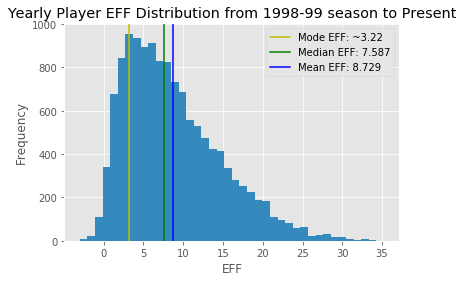

In [12]:
plot_stat_dist('eff')

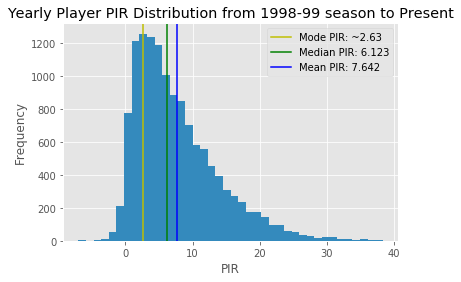

In [13]:
plot_stat_dist('pir')

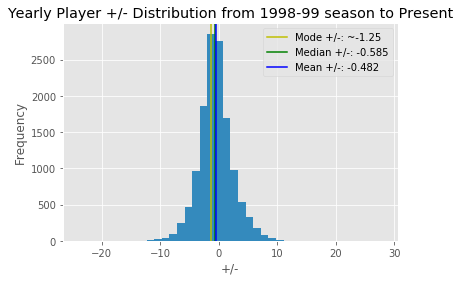

In [14]:
plot_stat_dist('+/-')

## Now let's group the player data by player_id and season, so that we can pull the statistic values from a prior year, and use those as features for a team based on roster. 

First, we'll group the dataframe by players and season. We do this instead of grouping by teams and season, to allow for us to account for roster changes season over season.

We can then reference player_id values for the target season to ensure we're selecting the right features (i.e, player statistics from the previous year, regardless of team affiliation). 

In [15]:
# First we'll group just by player so we can check if a particular season is relevant to them. 

df_by_player = df_nba.groupby(['player_id'])


In [16]:
# Here we group by both player and season so that we can pull particular efficiency scores per player per year.

df_by_p_s = df_nba.groupby(['player_id','season'])


## Now, we can iterate through team rosters by season to pull the prior year's efficiency metrics per player. 

Investigate roster dataframe to determine how to properly pull ['eff'] from player dataframe.

In [17]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     630 non-null    object
 1   team    630 non-null    int64 
 2   season  630 non-null    object
 3   roster  630 non-null    object
dtypes: int64(1), object(3)
memory usage: 19.8+ KB


Again, we can drop the '_id' column, as this is just a mongo convention

In [18]:
df_r.drop(columns = ['_id'], inplace = True)

In [19]:
df_r.head()

,team,season,roster
0,1610612737,1998-99,"[673, 1533, 1544, 87, 1516, 3, 1852, 111, 770,..."
1,1610612738,1998-99,"[692, 952, 1477, 1800, 344, 368, 35, 65, 72, 1..."
2,1610612739,1998-99,"[692, 226, 682, 1510, 1538, 916, 198, 1507, 18..."
3,1610612740,1998-99,[]
4,1610612741,1998-99,"[457, 82, 699, 1869, 1736, 1757, 54, 1522, 160..."


## For sake of iteration, we'll need to get all unique team IDs and seasons into two separate arrays.

We'll then group the roster dataframe by team and season, and use Pandas' get_group() method to pull the roster for a given season. We'll then iterate through the roster to select player efficiency scores from the prior year in the df_by_player dataframe via player_id and season. 

In [20]:
teams = np.unique(df_team['TeamID'])
seasons = np.unique(df_nba['season'])

teams,seasons

(array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
        1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
        1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
        1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
        1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
        1610612762, 1610612763, 1610612764, 1610612765, 1610612766]),
 array(['1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03',
        '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
        '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15',
        '2015-16', '2016-17', '2017-18', '2018-19'], dtype=object))

## Group roster dataframe by team_id and season

In [21]:
df_r = df_r.groupby(['team','season'])


Because the line above just converted the variable df_r to a Pandas' groupby object, we'll need to call get_group() going forward to view and pull data.

Let's use our 'teams' and 'seasons' lists from above to do just that.

### Because we are interested in a pre-season prediction of wins, we want to ensure that we're only pulling player data from players who were on the roster at the beginning of the year. We can check for multiple entries for a player within a given year, and then ensure that we only upload a statistic on behalf of a player to the team on which they began a season.

In [22]:
#Generalized function for generating a feature matrix
def gen_X(teams,seasons,stat,n_p=17):  
    
    """
    PARAMETERS:
    
    teams - list of team IDs
    season - list of seasons
    stat - string of column title in player dataframe for statistic of interest
    n_p - int, number of players on a roster to consider. Defaults to 17 as this is the max number of active players
    a roster may have at a given time
    
    RETURNS:
    
    Feature matrix to be used for predicting wins and playoff rankings of teams
    """
    
    X = []

    # Index into each team
    for t in teams:

        # Index into each season
        for idx, s in enumerate(seasons):

            # We only care about prior year stats, and we can't index into the prior year if idx is 0
            if idx > 0:

                # create a row for our features array
                row = [int(t),s]

                #accumulator for efficiency scores
                lst_stat = []

                # select roster and loop through player_ids to pull efficiency scores from prior year in df_by_player
                roster = list(df_r.get_group((t.item(),s))['roster'])

                for p in roster[0]:

                    #for sake of testing the code, make sure a player_id is in our dataset
                    if p in df_nba['player_id'].to_numpy():

                        #Check a given season is relevant to a player
                        if seasons[idx-1] in df_by_player.get_group(p)['season'].to_numpy():

                            # verify a player started the season with team
                            # the -1 index is because team order is reverse chronilogical

                            if t == df_by_p_s.get_group((p,s))['team_id'].to_numpy()[-1]:          

                                """Select a player's efficiency score from the prior season, because 
                                we want to predict outcomes of current year. 
                                The index 0 ensures we pull cummulative stats for players who 
                                spent the prior season on multiple teams."""

                                stat_ = df_by_p_s.get_group((p,seasons[idx-1]))[stat].to_numpy()[0]
                                lst_stat.append(int(stat_))
                

            #Create accumulator array to account for differing sizes in rosters
                final_stat = np.zeros(19)
                for idx,stat_ in enumerate(lst_stat):
                    final_stat[idx] = int(stat_)

                """Sort efficiency scores in descending order such that we are comparing players 
                of equal team hierarchical rank within feature columns"""
                # take n_p best players per efficiency statistic
                final_stat = np.sort(final_stat)[::-1][:n_p]

                row = np.concatenate((row,final_stat), axis = None)

                X.append(row)
    
    # Generate dataframe and properly name columns
    df_X = pd.DataFrame(X)
    
    col_names = dict()

    for idx,col in enumerate(df_X.columns):
        if idx>1:
            col_names[idx] = f'player_{stat}_rank{idx-1}'
        elif idx == 0:
            col_names[idx] = 'team_id'
        else:
            col_names[idx] = 'season'
    
    df_X.rename(columns = col_names, inplace=True)
    
    return df_X

In [23]:
df_X = gen_X(teams,seasons,'eff',10)

In [24]:
df_X.head()

,team_id,season,player_eff_rank1,player_eff_rank2,player_eff_rank3,player_eff_rank4,player_eff_rank5,player_eff_rank6,player_eff_rank7,player_eff_rank8,player_eff_rank9,player_eff_rank10
0,1610612737,1998-99,21.0,18.0,16.0,14.0,13.0,11.0,7.0,6.0,3.0,1.0
1,1610612737,1999-00,20.0,12.0,11.0,10.0,10.0,9.0,8.0,5.0,4.0,2.0
2,1610612737,2000-01,23.0,13.0,13.0,9.0,7.0,6.0,5.0,5.0,4.0,4.0
3,1610612737,2001-02,22.0,18.0,16.0,11.0,9.0,9.0,7.0,7.0,5.0,5.0
4,1610612737,2002-03,22.0,18.0,18.0,12.0,11.0,10.0,7.0,7.0,6.0,6.0


## We have our features matrix (X) above. Now onto our targets. 

In [25]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               624 non-null    object
 1   SeasonID          624 non-null    object
 2   TeamID            624 non-null    int64 
 3   TeamCity          624 non-null    object
 4   TeamName          624 non-null    object
 5   Conference        624 non-null    object
 6   ConferenceRecord  624 non-null    object
 7   PlayoffRank       624 non-null    int64 
 8   ClinchIndicator   620 non-null    object
 9   Division          624 non-null    object
 10  DivisionRecord    624 non-null    object
 11  DivisionRank      624 non-null    int64 
 12  WINS              624 non-null    int64 
 13  LOSSES            624 non-null    int64 
dtypes: int64(5), object(9)
memory usage: 68.4+ KB


This study is interested in just the wins per team per season, so let's pullout the pertinent columns.

In [26]:
df_team = df_team[['SeasonID','TeamID','WINS','LOSSES']]
df_team.head()

,SeasonID,TeamID,WINS,LOSSES
0,21998,1610612753,33,17
1,21998,1610612762,37,13
2,21998,1610612754,33,17
3,21998,1610612759,37,13
4,21998,1610612748,33,17


## Note: There are only 50 games played in the 1998 season, so we'll need to transform that data to estimate the 82 game win total so it's consistent with the rest of our data.

In [27]:
df_team['w'] = ((df_team['WINS'] / (df_team['WINS']+df_team['LOSSES'])) * 82).round()

In [28]:
df_team.rename(columns = {'TeamID': 'team_id'}, inplace= True)

Now we'll drop the 'WINS' and 'LOSSES' columns as they're extraneous.

In [29]:
df_team.drop(columns = ['WINS','LOSSES'], inplace = True)

In [30]:
np.unique(df_team['SeasonID']),np.unique(df_nba['season'])

(array(['21998', '21999', '22000', '22001', '22002', '22003', '22004',
        '22005', '22006', '22007', '22008', '22009', '22010', '22011',
        '22012', '22013', '22014', '22015', '22016', '22017', '22018'],
       dtype=object),
 array(['1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03',
        '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
        '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15',
        '2015-16', '2016-17', '2017-18', '2018-19'], dtype=object))

### We should also update our SeasonID columns so that its formatting is the same as that of 'season' in our df_X.

In [31]:
season1 = np.unique(df_nba['season'])[1:]
season2 = np.unique(df_team['SeasonID'])

d = dict()
for s1, s2 in zip(season1,season2):
    d[s2] = s1
    
d

{'21998': '1998-99',
 '21999': '1999-00',
 '22000': '2000-01',
 '22001': '2001-02',
 '22002': '2002-03',
 '22003': '2003-04',
 '22004': '2004-05',
 '22005': '2005-06',
 '22006': '2006-07',
 '22007': '2007-08',
 '22008': '2008-09',
 '22009': '2009-10',
 '22010': '2010-11',
 '22011': '2011-12',
 '22012': '2012-13',
 '22013': '2013-14',
 '22014': '2014-15',
 '22015': '2015-16',
 '22016': '2016-17',
 '22017': '2017-18',
 '22018': '2018-19'}

In [32]:
df_team['season'] = [d[s] for s in df_team['SeasonID']]

In [33]:
df_team.drop(columns = 'SeasonID', inplace = True)

In [34]:
# Let's get everthing nice and chronological
df_team.sort_values(by = ['team_id','season'], inplace=True)

In [35]:
df_team.head()

,team_id,w,season
6,1610612737,51.0,1998-99
56,1610612737,28.0,1999-00
83,1610612737,25.0,2000-01
109,1610612737,33.0,2001-02
136,1610612737,35.0,2002-03


In [36]:
df_team.info(),df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 6 to 611
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   team_id  624 non-null    int64  
 1   w        624 non-null    float64
 2   season   624 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 19.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   team_id            630 non-null    object
 1   season             630 non-null    object
 2   player_eff_rank1   630 non-null    object
 3   player_eff_rank2   630 non-null    object
 4   player_eff_rank3   630 non-null    object
 5   player_eff_rank4   630 non-null    object
 6   player_eff_rank5   630 non-null    object
 7   player_eff_rank6   630 non-null    object
 8   player_eff_rank7   630 non-null    object
 9   player_eff_rank8

(None, None)

## Uh-oh, looks like our shapes are different for our feature dataframe and our targets. Let's investigate the shape discrepancy.

In [37]:
np.unique(df_X['team_id'], return_counts = True)

(array(['1610612737', '1610612738', '1610612739', '1610612740',
        '1610612741', '1610612742', '1610612743', '1610612744',
        '1610612745', '1610612746', '1610612747', '1610612748',
        '1610612749', '1610612750', '1610612751', '1610612752',
        '1610612753', '1610612754', '1610612755', '1610612756',
        '1610612757', '1610612758', '1610612759', '1610612760',
        '1610612761', '1610612762', '1610612763', '1610612764',
        '1610612765', '1610612766'], dtype=object),
 array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]))

In [38]:
np.unique(df_team['team_id'], return_counts = True)

(array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
        1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
        1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
        1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
        1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
        1610612762, 1610612763, 1610612764, 1610612765, 1610612766]),
 array([21, 21, 21, 17, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 19]))

## Team_id 1610612740 only appears 17 times, and team_id 1610612766 only appears 19 times.

Perhaps this has to do with a team becoming defunct or moving locations. Let's figure out which franchises belong to these team_id values

In [39]:
np.unique(df_nba.loc[df_nba['team_id']==1610612740]['team_abbreviation'], return_counts = True), df_team.loc[df_team['team_id']==1610612740]['season']

((array(['NOH', 'NOK', 'NOP'], dtype=object), array([173,  34, 158])),
 124    2002-03
 153    2003-04
 202    2004-05
 223    2005-06
 253    2006-07
 266    2007-08
 307    2008-09
 345    2009-10
 366    2010-11
 412    2011-12
 440    2012-13
 466    2013-14
 489    2014-15
 527    2015-16
 553    2016-17
 575    2017-18
 619    2018-19
 Name: season, dtype: object)

In [40]:
np.unique(df_nba.loc[df_nba['team_id']==1610612766]['team_abbreviation'], return_counts = True), df_team.loc[df_team['team_id']==1610612766]['season']

((array(['CHA', 'CHH'], dtype=object), array([286,  73])),
 17     1998-99
 35     1999-00
 68     2000-01
 93     2001-02
 201    2004-05
 229    2005-06
 255    2006-07
 286    2007-08
 312    2008-09
 336    2009-10
 372    2010-11
 413    2011-12
 441    2012-13
 456    2013-14
 494    2014-15
 515    2015-16
 554    2016-17
 583    2017-18
 611    2018-19
 Name: season, dtype: object)

#### As suspected, both of the above franchises have undergone relocations in the most recent 20 years.

#### For New Orleans, we're missing the following seasons' data: 1998-99,1999-2000, 2000-01, 2001-02. 
#### For Charlotte, we're missing: 2002-03,2003-04

#### So, let's ensure that we're only pairing feature rows with records that actually have wins and playoff rank data.

In [41]:
# store wins and playoff ranks pertinent to each season by team as targets.

def get_y(df_X,df_y,y_col):
    
    """
    PARAMETERS:
    
    df_X: Pandas DataFrame containing feature values
    df_y: Pandas DataFrame containing target values
    y_col: list of column names of desired target values
    
    RETURNS:
    DataFrame with both features and target values to be used for model fitting. 
    
    """

    for y in y_col:
        
        arr_y = []
        
        for t,s in zip(df_X['team_id'],df_X['season']):
            # verify a season is pertinent to a given team
            if s not in df_y.loc[df_y['team_id']==int(t)]['season'].to_numpy():
                y_ = None
                arr_y.append(y_)

            else:
                y_ = df_y.loc[(df_y['team_id']==int(t)) & (df_y['season'] == s)][y].to_numpy()[0]
                arr_y.append(y_)
        
        arr_y = np.array(arr_y)
        
        df_X[y] = arr_y
    
    #get rid of rows with null values in target columns
    df_X.dropna(inplace = True)
    
    return df_X

In [42]:
df_X = gen_X(teams,seasons,'eff',10)

In [43]:
X_eff = get_y(df_X,df_team,['w'])

In [44]:
X_eff.head()

,team_id,season,player_eff_rank1,player_eff_rank2,player_eff_rank3,player_eff_rank4,player_eff_rank5,player_eff_rank6,player_eff_rank7,player_eff_rank8,player_eff_rank9,player_eff_rank10,w
0,1610612737,1998-99,21.0,18.0,16.0,14.0,13.0,11.0,7.0,6.0,3.0,1.0,51
1,1610612737,1999-00,20.0,12.0,11.0,10.0,10.0,9.0,8.0,5.0,4.0,2.0,28
2,1610612737,2000-01,23.0,13.0,13.0,9.0,7.0,6.0,5.0,5.0,4.0,4.0,25
3,1610612737,2001-02,22.0,18.0,16.0,11.0,9.0,9.0,7.0,7.0,5.0,5.0,33
4,1610612737,2002-03,22.0,18.0,18.0,12.0,11.0,10.0,7.0,7.0,6.0,6.0,35


## Let's begin fitting and experimenting with the number of features to see if there's an optimal number of best player individual efficiency scores to include per team. A range of 5 to 17 feels approriate as 5 players need to be on the floor at a given time, and there can be a maximum of 17 players on the active roster of a team.

## We'll look at individual EFF, PIR, and +/- scores

Because none of our data is categorical, and we can't ensure a linear relationship between our features and targets, a GradientBoost Regressor feels appropriate for regular season wins predictions.

In [45]:
import sklearn

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

### Score models by number of features and plot

In [47]:
def score_n_features(stat):
    
    fig,ax = plt.subplots()
    """
    PARAMETERS:
    stat - string, column title of statistic of interest
    
    RETURNS:
    None - plots Gradient Boosting model scores associated with number of features
    """

    lst_score = []
    lst_n = []
    for n in range(5,18):

        #generate features and targets
        df_X = gen_X(teams,seasons,stat,n)
        X = get_y(df_X,df_team,['w'])
        
        y_w = X['w']
        
        X = X.drop(columns=['team_id','season','w'])
        
        #fit and score model
        gb_w = GradientBoostingRegressor()
        score = np.mean(cross_val_score(gb_w,X,y_w,cv=5))

        lst_score.append(round(score,2))
        lst_n.append(n)
    
    max_score = np.max(lst_score)
    max_feat = lst_n[np.argmax(lst_score)]
    ax.plot(lst_n,lst_score)
    ax.annotate(f'({max_feat},{max_score})',(max_feat,max_score))
    ax.set_title(f'Number of Features vs. Model Score {stat}')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('R^2 Score')
    
    return None
    

## EFF results

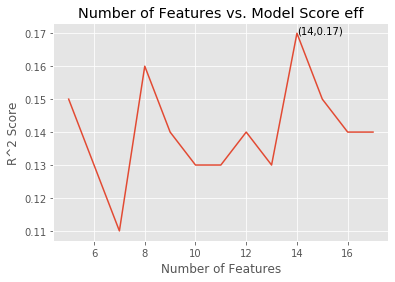

In [48]:
eff_ind = score_n_features('eff')

In [49]:
eff_ind

## PIR results

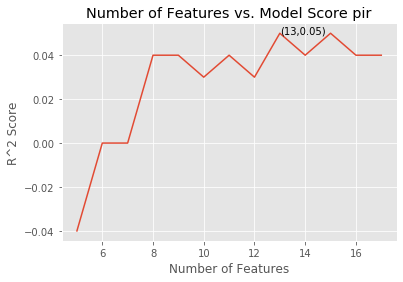

In [50]:
pir_ind = score_n_features('pir')

In [51]:
pir_ind

## +/- results

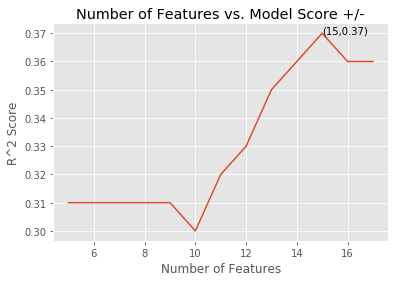

In [52]:
pm_ind = score_n_features('+/-')

In [53]:
pm_ind

## Individual Player Features Model Summary

#### Optimized Individual Player EFF: 
14 players, cross validated R^2 of 0.17
#### Optimized Individual Player PIR: 
13 players, R^2 of 0.05
#### Optimized Individual Player +/-: 
15 players, R^2 of 0.37



# Circle back


## So we know which feature levels perform the best for the above models. Let's take a peak at feature importances to see if we can pinpoint which feature importances are most informative.

### Feature importances can be a bit misleading. While they describe the extent to which a feature helps a model make accurate predictions, they don't describe directionality, nor correlation of the features to a particular target. 

### Let's compare feature importances and Pearson Correlation p-values for each feature to provide a detailed understanding of each feature.

In [54]:
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr

### Below is a plotting function that calculates feature importance for a given model and plots the boxplot distributions of those features. 

In [55]:
def plot_imp(stat,n_feat):
    
    
    cols = 4
    if n_feat%cols == 0:
        rows = n_feat/cols
    else:
        rows = (n_feat//cols) + 1

    fig, ax = plt.subplots(rows, cols, figsize=(15,12))
    """
    PARAMETERS:
    stat - string, Column title for statistic of interest
    n_feat - int, number of features to be included in model
    
    RETURNS:
    -Array of feature titles sorted by importance
    -Plots boxplot distributions of features in order of features in order of feature importance.
    """
    
    df_X = gen_X(teams,seasons,stat,n_feat)
    X = get_y(df_X,df_team,['w'])
    y_w = X['w']
    X = X.drop(columns=['team_id','season','w'])
    
    #fit and get feature scores of model
    gb_w = GradientBoostingRegressor()
    gb_w.fit(X,y_w)
    imp = permutation_importance(gb_w,X,y_w)
    feat_imp = imp['importances_mean']
    feat_imp
    
    # rank feature importances and plot their underlying distribution
    order = np.argsort(feat_imp)[::-1]
    for idx,col in enumerate(X.columns[order]):
        
        
        mean = round(np.mean(X[col].astype('float')),2)
        std = round(np.std(X[col].astype('float')),2)
        
        ax[idx//cols,idx%cols].boxplot(df_X[col].astype('float'), labels = [f'Mean:{mean},Std:{std}'])
        ax[idx//cols,idx%cols].set_title(f'{col}, Rank: {idx+1}')

    plt.tight_layout()
       
    return X.columns[order]
    

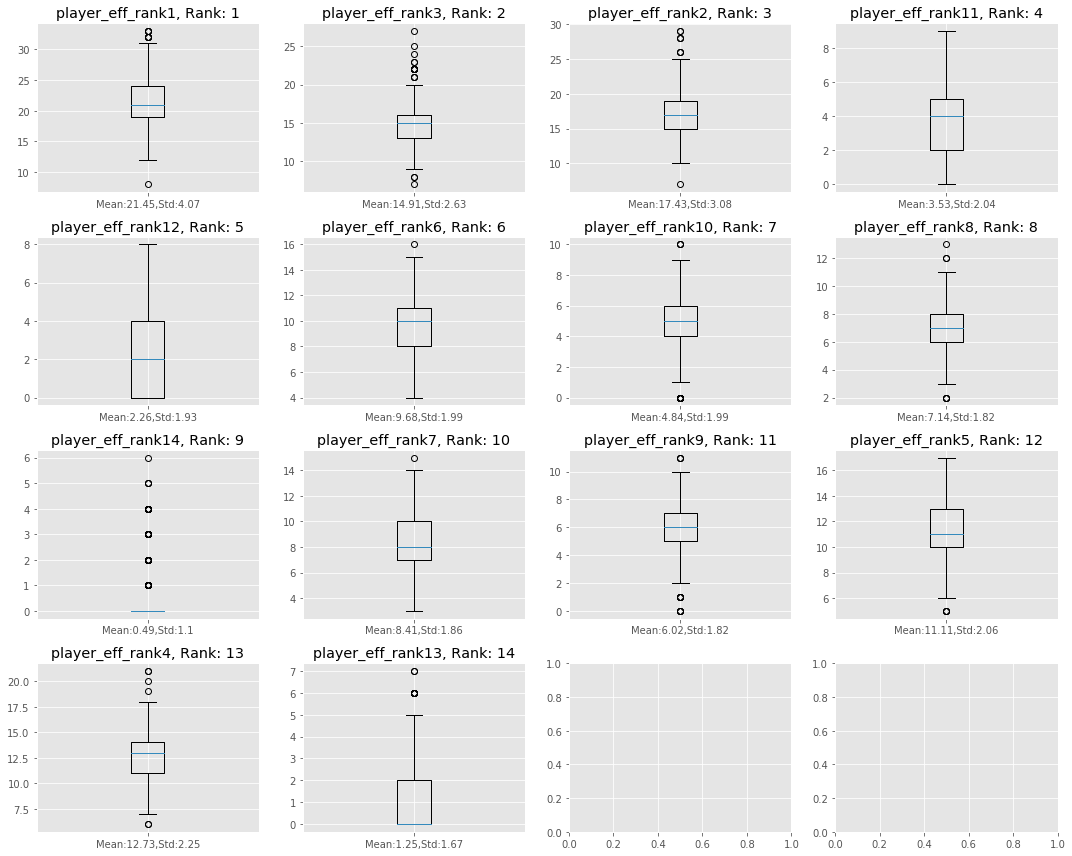

In [56]:
eff_box = plot_imp('eff',14)

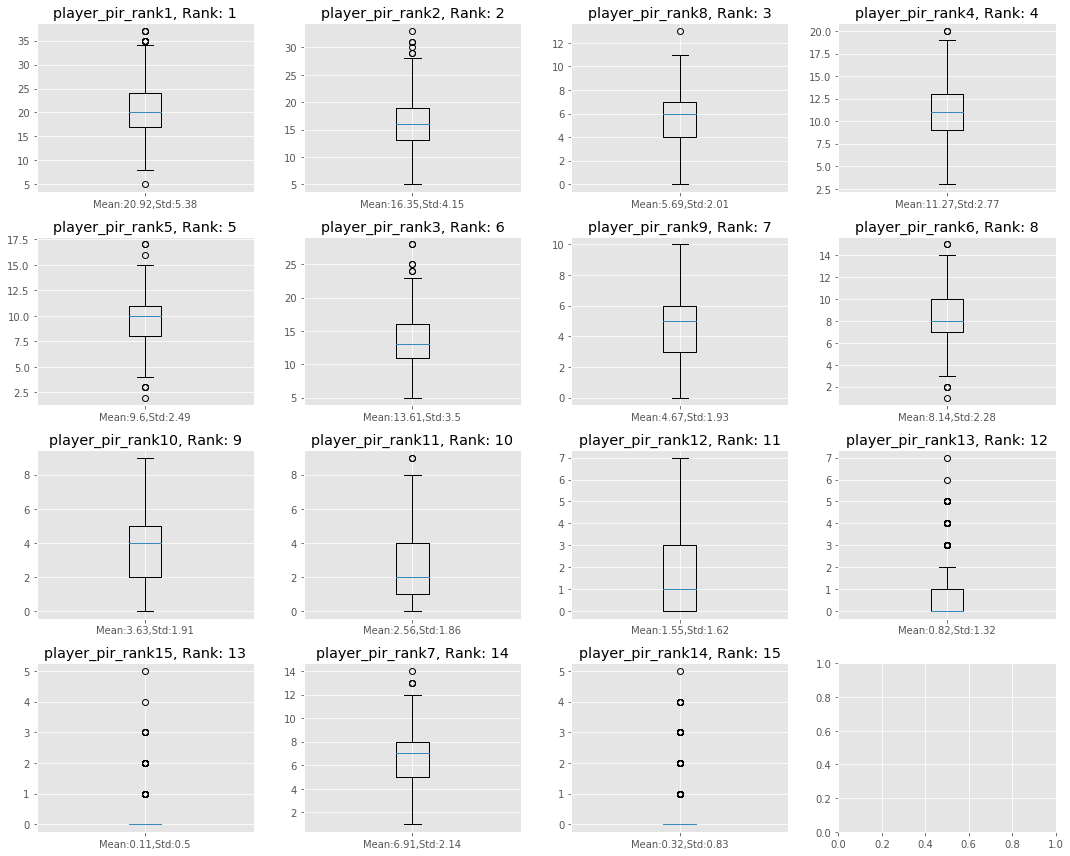

In [57]:
pir_box = plot_imp('pir',15)

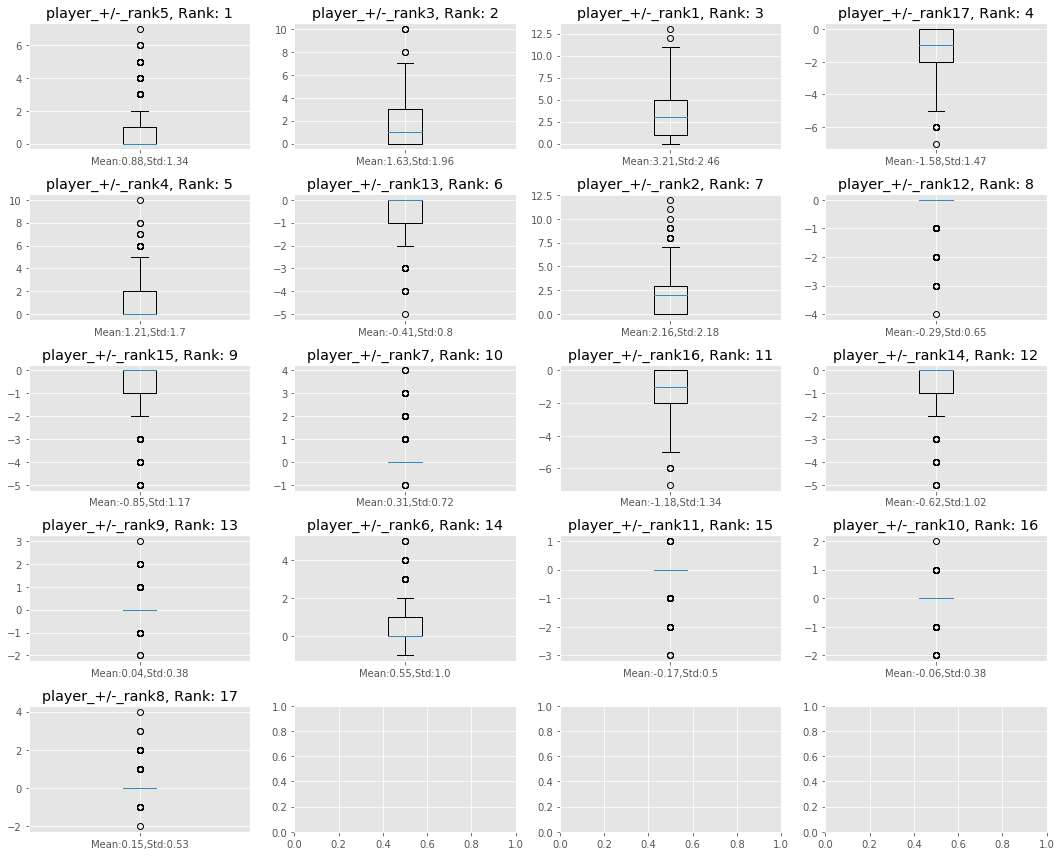

In [58]:
pm_box = plot_imp('+/-',17)


## Feature Importance by Individual Metric Scores Summary

### Across all statistics - EFF, PIR, and +/-:

#### Feature importance was not parallel to the hierarchical rankings of player statistics. However, the first and second-best player scores across all metrics found themselves in the top three of importance

#### Only for +/- did the top 5 player scores appear in the top five feature importances as well. This could suggest that +/- is the most accurate metric to quantify a player's contribution to a team's success. 


## Bringing things back into focus, the top R^2 of 0.37 (+/-, 15 players) still leaves plenty to be desired. Let's pivot to some aggregated team statistics and see if those are more informative. 

In [59]:
#Generalized function for generating a feature matrix with average team statistics based on roster
def gen_team_X(teams,seasons,stats):  
    
    """
    PARAMETERS:
    
    teams - list of team IDs
    season - list of seasons
    stats - list of strings: column titles in player dataframe for statistic of interest
    
    RETURNS:
    
    Feature matrix to be used for predicting wins and playoff rankings of teams
    """
    
    X = []

    # Index into each team
    for t in teams:

        # Index into each season
        for idx, s in enumerate(seasons):

            # We only care about prior year stats, and we can't index into the prior year if idx is 0
            if idx > 0:

                # create a row for our features array
                row = [int(t),s]

                for stat in stats:    
                    
                    #accumulator for efficiency scores
                    lst_stat = []

                    # select roster and loop through player_ids to pull efficiency scores from prior year in df_by_player
                    roster = list(df_r.get_group((t.item(),s))['roster'])

                    for p in roster[0]:

                        #for sake of testing the code, make sure a player_id is in our dataset
                        if p in df_nba['player_id'].to_numpy():

                            #Check a given season is relevant to a player
                            if seasons[idx-1] in df_by_player.get_group(p)['season'].to_numpy():

                                # verify a player started the season with team
                                # the -1 index is because team order is reverse chronilogical

                                if t == df_by_p_s.get_group((p,s))['team_id'].to_numpy()[-1]:          

                                    """Select a player's efficiency score from the prior season, because 
                                    we want to predict outcomes of current year. 
                                    The index 0 ensures we pull cummulative stats for players who 
                                    spent the prior season on multiple teams."""
                                    stat_ = df_by_p_s.get_group((p,seasons[idx-1]))[stat].to_numpy()[0]
                                    lst_stat.append(int(stat_))
                    
                    if len(lst_stat)<1:
                        final_stat = None
                    #take mean of statistic and append to row
                    else:
                        final_stat = np.mean(lst_stat)
                    
                    row = np.concatenate((row,final_stat), axis = None)



                # add roster average statistics to df
                X.append(row)
    
    # Generate dataframe and properly name columns
    df_X = pd.DataFrame(X)
    
    col_names = dict()

    for idx,col in enumerate(df_X.columns):
        if idx>1:
            col_names[idx] = stats[idx-2]
        elif idx == 0:
            col_names[idx] = 'team_id'
        else:
            col_names[idx] = 'season'
    
    df_X.rename(columns = col_names, inplace=True)
    
    return df_X

In [60]:
df_X_team = gen_team_X(teams,seasons,['eff','pir','+/-'])

In [61]:
df_X_team.shape

(630, 5)

In [62]:
get_y(df_X_team,df_team,['w'])

,team_id,season,eff,pir,+/-,w
0,1610612737,1998-99,11.0,8.3,0.5,51
1,1610612737,1999-00,9.1,6.4,0.4,28
2,1610612737,2000-01,7.3076923076923075,5.153846153846154,-1.6923076923076923,25
3,1610612737,2001-02,8.4,5.866666666666666,-1.2,33
4,1610612737,2002-03,9.692307692307692,6.846153846153846,-2.3846153846153846,35
...,...,...,...,...,...,...
625,1610612766,2014-15,10.153846153846153,9.692307692307692,-0.6153846153846154,33
626,1610612766,2015-16,9.071428571428571,8.571428571428571,-0.7142857142857143,48
627,1610612766,2016-17,9.714285714285714,9.5,0.5,36
628,1610612766,2017-18,12.272727272727273,12.0,0.09090909090909091,36


In [63]:
def score_team():
    
    """
    PARAMETERS:
    None
    
    RETURNS:
    None - prints Gradient Boosting model scores associated with number of features
    """

    #generate features and targets
    df_X = gen_team_X(teams,seasons,['eff','pir','+/-'])
    X = get_y(df_X,df_team,['w'])

    y_w = X['w']

    X = X.drop(columns=['team_id','season','w'])

    #fit and score model
    gb_w = GradientBoostingRegressor()
    score = round(np.mean(cross_val_score(gb_w,X,y_w,cv=5)),3)

    print(f'Aggregate team statistics model score: {score}')
    
    return None

In [64]:
score_team()

Aggregate team statistics model score: 0.394


## So we've improved about ~.025 from our individual +/- model before to R^2 =~0.39

### Time for another round of feature importance analysis. 

### Aggregate Team statistics

In [65]:
df_X = gen_team_X(teams,seasons,['eff','pir','+/-'])
X = get_y(df_X,df_team,['w'])

y_w = X['w']

X = X.drop(columns=['team_id','season','w'])

In [66]:
#fit and get feature scores of model
gb_w = GradientBoostingRegressor()
gb_w.fit(X,y_w)
imp = permutation_importance(gb_w,X,y_w)
feat_imp = imp['importances_mean']
feat_imp

array([0.35524492, 0.19087338, 0.84473644])

In [67]:
# Broadcast ordered indices onto X column titles to determine which features are most important, in descending order
idx = np.argsort(feat_imp)
feat_rank_agg = X.columns[idx[::-1]]
feat_rank_agg

Index(['+/-', 'eff', 'pir'], dtype='object')

## Feature Importance by Average Team Stats Summary

### Team Plus-Minus average seems to be most predictive of a team's seasonal outcome. More than twice as much as EFF and four times as much as PIR

## Let's try and beat an R^2 of 0.394.
### Idea: because an inclusion of all three efficiency metrics seemed to improve our model above, let's fit the model including the individual player efficiency score for all three metrics. 


In [68]:
# Generate dataframes for all three metrics
    
df_X_eff = gen_X(teams,seasons,'eff')
df_X_pir = gen_X(teams,seasons,'pir')
df_X_pm = gen_X(teams,seasons,'+/-')

In [69]:
# join dataframes

df_m1 = pd.merge(df_X_eff,df_X_pir, on = ['team_id','season'], how='inner')
df_all_ind = pd.merge(df_m1,df_X_pm, on = ['team_id','season'], how='inner')

In [70]:
X = get_y(df_all_ind,df_team,['w'])

In [71]:
y_w = X['w']

X = X.drop(columns=['team_id','season','w'])

In [72]:
# Fit and score

gb_w = GradientBoostingRegressor()
np.mean(cross_val_score(gb_w,X,y_w,cv=20))

0.32429671703547075